## Container Price Prediction

In [21]:
import pandas as pd

In [22]:

# --- Step 1: Load Excel with correct header row ---
# USE ONLY THE BASE FILE THE CLIENT HAS SENT HERE

file_path = "Shanghai Containerized Freight Index.xlsx"
df = pd.read_excel(file_path, header=1)

In [23]:
# --- Step 2: Normalize column names ---
df.columns = df.columns.str.strip().str.lower()

# --- Step 3: Rename columns to simple names ---
rename_map = {
    "the period (yyyy-mm-dd)": "date",
    "comprehensive index": "comprehensive_index",
    "europe (base port)": "europe_base_port",
    "mediterranean (base port)": "mediterranean_base_port",
    "persian gulf and red sea (dubai)": "persian_gulf_red_sea_dubai"
}
df.rename(columns=rename_map, inplace=True)

print("Columns after cleaning:", df.columns.tolist())

Columns after cleaning: ['date', 'comprehensive_index', 'europe_base_port', 'mediterranean_base_port', 'persian_gulf_red_sea_dubai']


In [24]:
# --- Step 4: Fix number formatting (comma decimals -> float) ---
for col in ["comprehensive_index", "europe_base_port",
            "mediterranean_base_port", "persian_gulf_red_sea_dubai"]:
    df[col] = (df[col]
               .astype(str)
               .str.replace(",", ".", regex=False)  # replace commas with dots
               .astype(float))

# --- Step 5: Parse dates and sort ---
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)
df.head()

,date,comprehensive_index,europe_base_port,mediterranean_base_port,persian_gulf_red_sea_dubai
0,2018-01-05,816.58,888.0,738.0,433.0
1,2018-01-12,839.72,897.0,759.0,450.0
2,2018-01-19,840.36,891.0,761.0,572.0
3,2018-01-26,858.60,907.0,772.0,631.0
4,2018-02-02,883.59,912.0,797.0,611.0


In [25]:
# --- Step 6: Create lag features ---
lag_weeks = 3
for col in ["comprehensive_index", "europe_base_port",
            "mediterranean_base_port", "persian_gulf_red_sea_dubai"]:
    for lag in range(1, lag_weeks + 1):
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

df.head()

,date,comprehensive_index,europe_base_port,mediterranean_base_port,persian_gulf_red_sea_dubai,comprehensive_index_lag_1,comprehensive_index_lag_2,comprehensive_index_lag_3,europe_base_port_lag_1,europe_base_port_lag_2,europe_base_port_lag_3,mediterranean_base_port_lag_1,mediterranean_base_port_lag_2,mediterranean_base_port_lag_3,persian_gulf_red_sea_dubai_lag_1,persian_gulf_red_sea_dubai_lag_2,persian_gulf_red_sea_dubai_lag_3
0,2018-01-05,816.58,888.0,738.0,433.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-12,839.72,897.0,759.0,450.0,816.58,NaN,NaN,888.0,NaN,NaN,738.0,NaN,NaN,433.0,NaN,NaN
2,2018-01-19,840.36,891.0,761.0,572.0,839.72,816.58,NaN,897.0,888.0,NaN,759.0,738.0,NaN,450.0,433.0,NaN
3,2018-01-26,858.60,907.0,772.0,631.0,840.36,839.72,816.58,891.0,897.0,888.0,761.0,759.0,738.0,572.0,450.0,433.0
4,2018-02-02,883.59,912.0,797.0,611.0,858.60,840.36,839.72,907.0,891.0,897.0,772.0,761.0,759.0,631.0,572.0,450.0


In [26]:
# --- Step 7: Rolling averages ---
rolling_windows = [3, 6]
for col in ["comprehensive_index", "europe_base_port",
            "mediterranean_base_port", "persian_gulf_red_sea_dubai"]:
    for window in rolling_windows:
        df[f"{col}_rollmean_{window}"] = df[col].shift(1).rolling(window).mean()

df.head()

,date,comprehensive_index,europe_base_port,mediterranean_base_port,persian_gulf_red_sea_dubai,comprehensive_index_lag_1,comprehensive_index_lag_2,comprehensive_index_lag_3,europe_base_port_lag_1,europe_base_port_lag_2,...,persian_gulf_red_sea_dubai_lag_2,persian_gulf_red_sea_dubai_lag_3,comprehensive_index_rollmean_3,comprehensive_index_rollmean_6,europe_base_port_rollmean_3,europe_base_port_rollmean_6,mediterranean_base_port_rollmean_3,mediterranean_base_port_rollmean_6,persian_gulf_red_sea_dubai_rollmean_3,persian_gulf_red_sea_dubai_rollmean_6
0,2018-01-05,816.58,888.0,738.0,433.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-12,839.72,897.0,759.0,450.0,816.58,NaN,NaN,888.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-19,840.36,891.0,761.0,572.0,839.72,816.58,NaN,897.0,888.0,...,433.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-26,858.60,907.0,772.0,631.0,840.36,839.72,816.58,891.0,897.0,...,450.0,433.0,832.220000,NaN,892.000000,NaN,752.666667,NaN,485.0,NaN
4,2018-02-02,883.59,912.0,797.0,611.0,858.60,840.36,839.72,907.0,891.0,...,572.0,450.0,846.226667,NaN,898.333333,NaN,764.000000,NaN,551.0,NaN


In [27]:
# --- Step 8: Drop rows with NaNs from lag/rolling ---
df = df.dropna().reset_index(drop=True)
print(df.head(10))


        date  comprehensive_index  europe_base_port  mediterranean_base_port  \
0 2018-02-14               867.16             905.0                    791.0   
1 2018-02-23               854.19             916.0                    797.0   
2 2018-03-02               772.45             827.0                    721.0   
3 2018-03-09               729.49             791.0                    701.0   
4 2018-03-16               675.46             741.0                    665.0   
5 2018-03-23               646.59             704.0                    650.0   
6 2018-03-30               658.68             633.0                    615.0   
7 2018-04-04               654.17             617.0                    616.0   
8 2018-04-13               659.74             585.0                    600.0   
9 2018-04-20               674.58             584.0                    601.0   

   persian_gulf_red_sea_dubai  comprehensive_index_lag_1  \
0                       579.0                     871.76   

## Visualize indexes over time
Below are time-series plots for the main indexes and their 3-week rolling means. Run the cell(s) to render the charts.

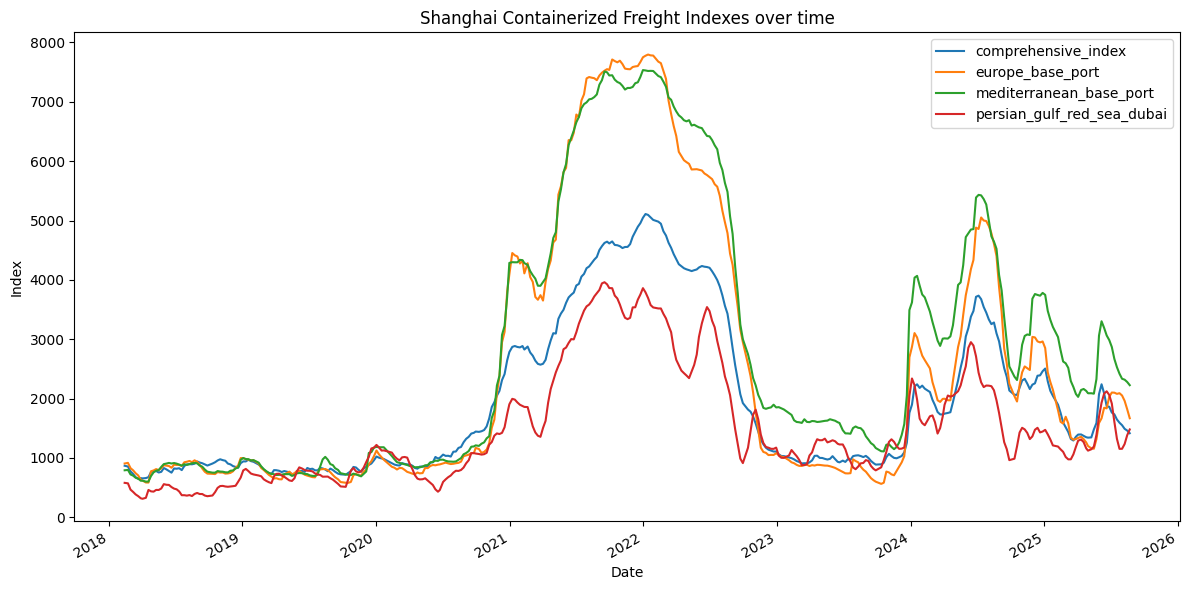

In [28]:
# Plot raw indexes over time
import matplotlib.pyplot as plt
# Use a seaborn-like style if available


# Prepare dataframe for plotting (use date as index)
df_plot = df.copy()
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_plot = df_plot.set_index('date')
cols = ['comprehensive_index', 'europe_base_port', 'mediterranean_base_port', 'persian_gulf_red_sea_dubai']

ax = df_plot[cols].plot(figsize=(12,6), linewidth=1.5)
ax.set_title('Shanghai Containerized Freight Indexes over time')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
plt.tight_layout()
plt.show()

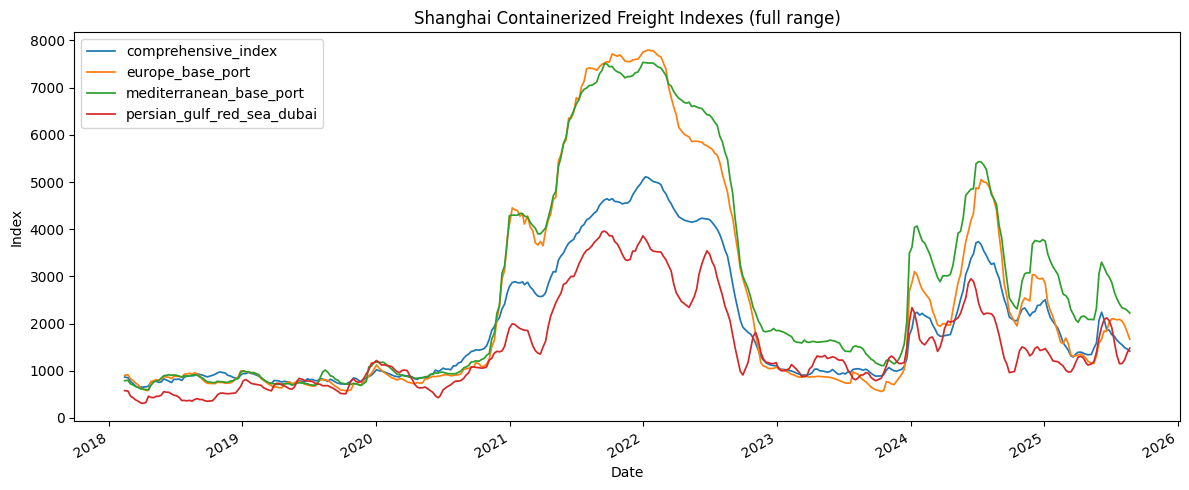

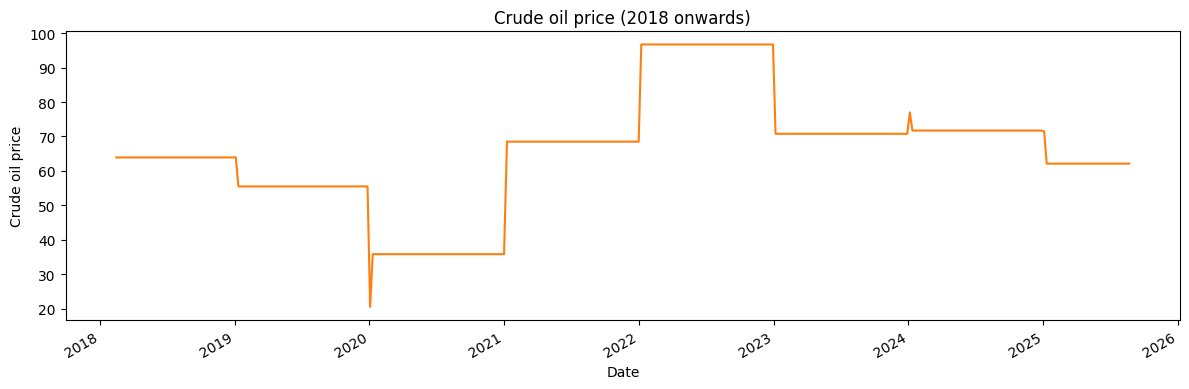

In [29]:
# Merge the loaded `oil_df` into `df` and plot indexes (full range) + oil price (separate plot from 2018 onwards)
import matplotlib.pyplot as plt

if 'oil_df' not in globals() or oil_df.empty:
    print("oil_df not found or empty. Run the oil loader cell first (the cell that creates `oil_df`).")
else:
    # Ensure date columns are datetimes and timezone-naive
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    oil_df['date'] = pd.to_datetime(oil_df['date'], errors='coerce')
    try:
        if oil_df['date'].dt.tz is not None:
            oil_df['date'] = oil_df['date'].dt.tz_convert('UTC').dt.tz_localize(None)
    except Exception:
        try:
            oil_df['date'] = oil_df['date'].dt.tz_localize(None)
        except Exception:
            pass

    # Merge on date
    merged = df.merge(oil_df[['date', 'oil_price']], on='date', how='left')
    # Fill missing oil prices sensibly
    merged['oil_price'] = merged['oil_price'].ffill().bfill()

    # Prepare plot frame
    df_plot = merged.set_index('date')
    cols = ['comprehensive_index', 'europe_base_port', 'mediterranean_base_port', 'persian_gulf_red_sea_dubai']

    # --- Figure 1: Indexes over full range ---
    fig, ax = plt.subplots(figsize=(12,5))
    df_plot[cols].plot(ax=ax, linewidth=1.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Index')
    ax.set_title('Shanghai Containerized Freight Indexes (full range)')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- Figure 2: Oil price from 2018 onwards (separate plot) ---
    oil_series = df_plot['oil_price'] if 'oil_price' in df_plot.columns else None
    if oil_series is None or oil_series.dropna().empty:
        print('No oil_price data available to plot.')
    else:
        oil_2018 = oil_series[oil_series.index >= pd.to_datetime('2018-01-01')]
        if oil_2018.dropna().empty:
            print('No oil data from 2018 onwards to plot.')
        else:
            fig, ax = plt.subplots(figsize=(12,4))
            oil_2018.plot(ax=ax, color='tab:orange', linewidth=1.5)
            ax.set_xlabel('Date')
            ax.set_ylabel('Crude oil price')
            ax.set_title('Crude oil price (2018 onwards)')
            plt.tight_layout()
            plt.show()
